In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import os

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Swish activation function
def swish(x):
    return x * tf.nn.sigmoid(x)

# Load EuroSAT dataset
(ds_train, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Define class names
class_names = ds_info.features['label'].names
num_classes = len(class_names)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocess function
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [128, 128])  # 128x128 input
    image = data_augmentation(image)
    return image, label


2025-06-16 16:35:36.554024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 16:35:36.948400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750091737.096104   58710 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750091737.138008   58710 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750091737.440441   58710 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

# Apply preprocessing and batching
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Create validation split
ds_train_size = int(ds_info.splits['train'].num_examples * 0.8)
ds_val_size = int(ds_train_size * 0.1)
ds_train = ds_train.shuffle(1000)
ds_val = ds_train.take(ds_val_size)
ds_train = ds_train.skip(ds_val_size)

ds_train = ds_train.map(preprocess, AUTOTUNE).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_val = ds_val.map(preprocess, AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.map(preprocess, AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [3]:

# Build CNN model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    
    # Conv Block 1
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Activation(swish),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Activation(swish),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Conv Block 2
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Activation(swish),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Activation(swish),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Conv Block 3
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Activation(swish),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Activation(swish),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Dense Layers
    layers.Flatten(),
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Activation(swish),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 8,681,258 (33.12 MB)

 Trainable params: 8,679,850 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [4]:

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('CNN_best_model.h5', save_best_only=True, monitor='val_accuracy')
]

# Train the model
EPOCHS = 35
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/35


2025-06-16 16:35:55.038600: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1750091756.203833   58920 service.cc:152] XLA service 0x7f24d4002700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750091756.203881   58920 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-16 16:35:56.373721: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750091757.090416   58920 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750091769.739061   58920 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4516 - loss: 2.7214

608/608 ━━━━━━━━━━━━━━━━━━━━ 92s 118ms/step - accuracy: 0.4518 - loss: 2.7206 - val_accuracy: 0.3319 - val_loss: 3.2494 - learning_rate: 0.0010
Epoch 2/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6853 - loss: 1.5340

608/608 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.6853 - loss: 1.5338 - val_accuracy: 0.5718 - val_loss: 1.9187 - learning_rate: 0.0010
Epoch 3/35
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7573 - loss: 1.2850

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.7573 - loss: 1.2849 - val_accuracy: 0.7875 - val_loss: 1.2121 - learning_rate: 0.0010
Epoch 4/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8106 - loss: 1.1283 - val_accuracy: 0.7699 - val_loss: 1.3103 - learning_rate: 0.0010
Epoch 5/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8371 - loss: 1.0512

608/608 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.8371 - loss: 1.0512 - val_accuracy: 0.8444 - val_loss: 1.0220 - learning_rate: 0.0010
Epoch 6/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.8453 - loss: 1.0052 - val_accuracy: 0.6741 - val_loss: 1.5734 - learning_rate: 0.0010
Epoch 7/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8524 - loss: 0.9972 - val_accuracy: 0.5079 - val_loss: 3.1058 - learning_rate: 0.0010
Epoch 8/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8618 - loss: 0.9481 - val_accuracy: 0.4995 - val_loss: 2.4464 - learning_rate: 0.0010
Epoch 9/35
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8951 - loss: 0.7630

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.8952 - loss: 0.7628 - val_accuracy: 0.8875 - val_loss: 0.7219 - learning_rate: 5.0000e-04
Epoch 10/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9106 - loss: 0.6247 - val_accuracy: 0.8676 - val_loss: 0.7413 - learning_rate: 5.0000e-04
Epoch 11/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9163 - loss: 0.6117 - val_accuracy: 0.7718 - val_loss: 1.1676 - learning_rate: 5.0000e-04
Epoch 12/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9178 - loss: 0.6061 - val_accuracy: 0.8745 - val_loss: 0.7262 - learning_rate: 5.0000e-04
Epoch 13/35
605/608 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9382 - loss: 0.5264

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9382 - loss: 0.5261 - val_accuracy: 0.9282 - val_loss: 0.5017 - learning_rate: 2.5000e-04
Epoch 14/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.9496 - loss: 0.4194 - val_accuracy: 0.9111 - val_loss: 0.5283 - learning_rate: 2.5000e-04
Epoch 15/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9528 - loss: 0.3957 - val_accuracy: 0.8389 - val_loss: 0.7916 - learning_rate: 2.5000e-04
Epoch 16/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9534 - loss: 0.3858 - val_accuracy: 0.9273 - val_loss: 0.4766 - learning_rate: 2.5000e-04
Epoch 17/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9572 - loss: 0.3734 - val_accuracy: 0.9106 - val_loss: 0.5313 - learning_rate: 2.5000e-04
Epoch 18/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9573 - loss: 0.3841 - val_accuracy: 0.9120 - val_loss: 0.5509 - learning_rate: 2.5000e-04
Epoch 19/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - a

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9696 - loss: 0.3377 - val_accuracy: 0.9463 - val_loss: 0.3757 - learning_rate: 1.2500e-04
Epoch 21/35
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9759 - loss: 0.2848

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9759 - loss: 0.2848 - val_accuracy: 0.9468 - val_loss: 0.3684 - learning_rate: 1.2500e-04
Epoch 22/35
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9784 - loss: 0.2557

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9784 - loss: 0.2557 - val_accuracy: 0.9477 - val_loss: 0.3663 - learning_rate: 1.2500e-04
Epoch 23/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.9784 - loss: 0.2465 - val_accuracy: 0.9366 - val_loss: 0.3997 - learning_rate: 1.2500e-04
Epoch 24/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9820 - loss: 0.2332 - val_accuracy: 0.9472 - val_loss: 0.3564 - learning_rate: 1.2500e-04
Epoch 25/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9825 - loss: 0.2294 - val_accuracy: 0.9199 - val_loss: 0.4633 - learning_rate: 1.2500e-04
Epoch 26/35
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9802 - loss: 0.2237

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9802 - loss: 0.2237 - val_accuracy: 0.9509 - val_loss: 0.3490 - learning_rate: 1.2500e-04
Epoch 27/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9817 - loss: 0.2237 - val_accuracy: 0.9407 - val_loss: 0.3903 - learning_rate: 1.2500e-04
Epoch 28/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9824 - loss: 0.2225 - val_accuracy: 0.9509 - val_loss: 0.3337 - learning_rate: 1.2500e-04
Epoch 29/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9813 - loss: 0.2196 - val_accuracy: 0.9407 - val_loss: 0.3723 - learning_rate: 1.2500e-04
Epoch 30/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9797 - loss: 0.2200 - val_accuracy: 0.9296 - val_loss: 0.4156 - learning_rate: 1.2500e-04
Epoch 31/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.9829 - loss: 0.2196 - val_accuracy: 0.9222 - val_loss: 0.4386 - learning_rate: 1.2500e-04
Epoch 32/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - ac

608/608 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.9861 - loss: 0.2033 - val_accuracy: 0.9532 - val_loss: 0.3277 - learning_rate: 6.2500e-05
Epoch 33/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9897 - loss: 0.1796

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9897 - loss: 0.1796 - val_accuracy: 0.9537 - val_loss: 0.3193 - learning_rate: 6.2500e-05
Epoch 34/35
607/608 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9907 - loss: 0.1659

608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9907 - loss: 0.1659 - val_accuracy: 0.9551 - val_loss: 0.3036 - learning_rate: 6.2500e-05
Epoch 35/35
608/608 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9918 - loss: 0.1585 - val_accuracy: 0.9329 - val_loss: 0.4099 - learning_rate: 6.2500e-05


In [5]:

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test)
print(f'\n✅ Test Accuracy: {test_acc:.4f}')


169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.9539 - loss: 0.2993

✅ Test Accuracy: 0.9513


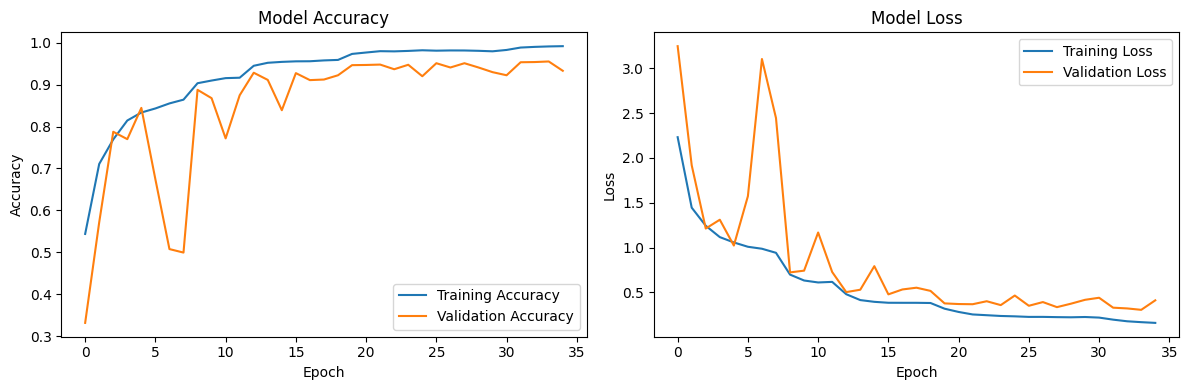

In [6]:

# ----------- Training History Plot -----------

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("CNN_training_history.png")  # Optional: Save plot
plt.show()


169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step


2025-06-16 16:53:20.969219: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


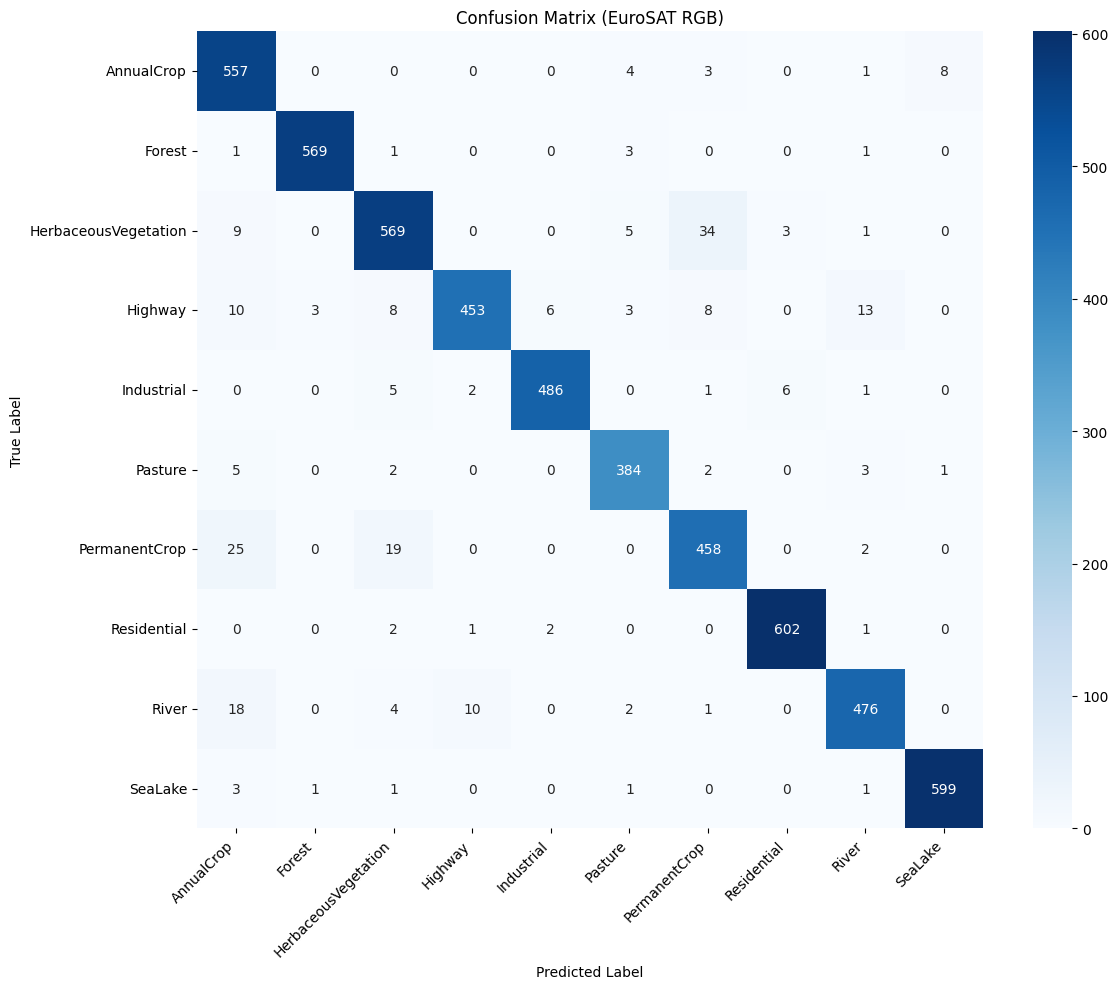

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random


# 2. Predict class labels
y_pred_probs = model.predict(ds_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Extract true labels from dataset
y_true = []
for _, labels in ds_test:
    labels = tf.convert_to_tensor(labels)
    if len(labels.shape) > 1 and labels.shape[-1] > 1:
        labels = tf.argmax(labels, axis=1)
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 4. Ensure both arrays are 1D integer class labels
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

# 5. Define class names (EuroSAT RGB has 10 classes)
class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

# 6. Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 7. Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (EuroSAT RGB)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

2025-06-16 16:53:22.717731: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-16 16:53:22.722395: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


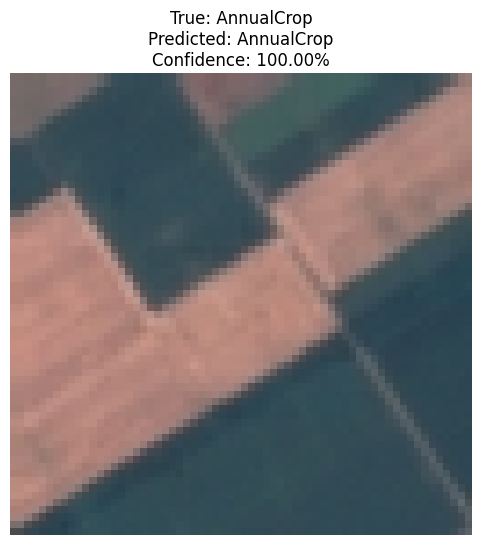


Prediction Details:
True class: AnnualCrop
Predicted class: AnnualCrop
Confidence score: 100.00%


In [8]:
# 8. Load the raw test dataset for random sample
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
# 9. Select a random image and label from the test set
unbatched_test = ds_test_raw.take(1000)  # Limit to 1000 samples to avoid memory issues
test_images = list(unbatched_test)
image, true_label = random.choice(test_images)

# 10. Preprocess the image for model prediction (match training preprocessing)
def preprocess_for_prediction(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [128, 128])  # Match the 128x128 input size
    return image

# 11. Prepare image for prediction (add batch dimension)
input_image = tf.expand_dims(preprocess_for_prediction(image), axis=0)

# 12. Get model prediction
pred_probs = model.predict(input_image)  # Shape: [1, 10]
pred_class = tf.argmax(pred_probs[0]).numpy()
confidence_score = tf.reduce_max(pred_probs[0]).numpy()

# 13. Display the original image with true and predicted labels
image_display = tf.cast(image, tf.uint8)  # Convert to uint8 for display
plt.figure(figsize=(6, 6))
plt.imshow(image_display)
plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[pred_class]}\nConfidence: {confidence_score:.2%}")
plt.axis('off')
plt.show()

# 14. Print prediction details
print(f"\nPrediction Details:")
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[pred_class]}")
print(f"Confidence score: {confidence_score:.2%}")